In [1]:
# https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential
%matplotlib inline

from __future__ import print_function
from time import time
import csv
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, autograd, gluon

In [2]:
batch_size = 2000
num_of_samples = 4000

In [3]:
X = []
y = []
with open('snapshots_Xy_180709_124937.csv', 'rb') as f:
    rdr = csv.reader(f, delimiter=',')
    next(rdr)
    # dat = [r for r in rdr]
    for row in rdr:
        X.append([float(x) for x in row[1:-1]])
        y.append(int(row[1]))

X = nd.array(X)
y = nd.array(y)

Xtrain = X[0:3000,:]
Xtest = X[3000:,:]
ytrain = y[0:3000]
ytest = y[3000:]

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtrain, ytrain),
                                   batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtest, ytest),
                                  batch_size=batch_size, shuffle=True)

In [4]:
mdl_ctx = mx.gpu()
dat_ctx = mx.gpu()

In [5]:
num_hidden = 80
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(256, activation="relu"))
    net.add(gluon.nn.Dense(128, activation="relu"))
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dense(32))

net.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=mdl_ctx)
trainer = gluon.Trainer(net.collect_params(), 'Adam', {'learning_rate': .01})

In [6]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [7]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(mdl_ctx).reshape((-1, 337))
        label = label.as_in_context(mdl_ctx).reshape((-1))
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [8]:
num_of_epochs = 200
smoothing_constant = .01

train_acc = []
test_acc = []
epo_time = []
epo_loss = []


for e in range(num_of_epochs):
    tic = time()
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(mdl_ctx).reshape((-1, 337))
        label = label.as_in_context(mdl_ctx).reshape((-1))
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
    
    train_acc.append(evaluate_accuracy(train_data, net))
    test_acc.append(evaluate_accuracy(test_data, net))
    epo_time.append(time() - tic)
    epo_loss.append(cumulative_loss/num_of_samples)
    
    print("Epoch %2d. Train_acc: %9.8f, Test_acc: %9.8f, Time: %9.8f, Loss: %9.8f" %
          (e, train_acc[e], test_acc[e], epo_time[e], epo_loss[e]))

Epoch  0. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.45194507, Loss: 376.55128516
Epoch  1. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.11197591, Loss: 681.37949609
Epoch  2. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.14931202, Loss: 123.26698438
Epoch  3. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.10583305, Loss: 291.98313281
Epoch  4. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.11093283, Loss: 298.45779687
Epoch  5. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.10620093, Loss: 250.30664062
Epoch  6. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.13728595, Loss: 205.77889844
Epoch  7. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.10948110, Loss: 255.07252344
Epoch  8. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.11060286, Loss: 259.85687500
Epoch  9. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.13980794, Loss: 222.55468750
Epoch 10. Train_acc: 0.95566667, Test_acc: 0.94800000, Time: 0.10948110, Loss: 1

Epoch 92. Train_acc: 0.98233333, Test_acc: 0.97600000, Time: 0.13531899, Loss: 0.02948234
Epoch 93. Train_acc: 0.98366667, Test_acc: 0.97600000, Time: 0.10969400, Loss: 0.02963170
Epoch 94. Train_acc: 0.98366667, Test_acc: 0.97900000, Time: 0.10844207, Loss: 0.02938843
Epoch 95. Train_acc: 0.98333333, Test_acc: 0.97700000, Time: 0.10888791, Loss: 0.02948413
Epoch 96. Train_acc: 0.98366667, Test_acc: 0.97500000, Time: 0.14022303, Loss: 0.02984543
Epoch 97. Train_acc: 0.98300000, Test_acc: 0.97900000, Time: 0.10552192, Loss: 0.02839075
Epoch 98. Train_acc: 0.98366667, Test_acc: 0.97800000, Time: 0.11015105, Loss: 0.02947561
Epoch 99. Train_acc: 0.98400000, Test_acc: 0.97500000, Time: 0.13613605, Loss: 0.02792489
Epoch 100. Train_acc: 0.98433333, Test_acc: 0.97700000, Time: 0.10846996, Loss: 0.02863575
Epoch 101. Train_acc: 0.98400000, Test_acc: 0.98000000, Time: 0.10922384, Loss: 0.02802453
Epoch 102. Train_acc: 0.98400000, Test_acc: 0.97700000, Time: 0.10704803, Loss: 0.02848079
Epoch 1

Epoch 184. Train_acc: 0.99033333, Test_acc: 0.98600000, Time: 0.11118412, Loss: 0.01856012
Epoch 185. Train_acc: 0.99066667, Test_acc: 0.98600000, Time: 0.10507393, Loss: 0.01885220
Epoch 186. Train_acc: 0.98966667, Test_acc: 0.98300000, Time: 0.13881993, Loss: 0.01800027
Epoch 187. Train_acc: 0.98733333, Test_acc: 0.98300000, Time: 0.10733604, Loss: 0.01854063
Epoch 188. Train_acc: 0.98933333, Test_acc: 0.98400000, Time: 0.10780215, Loss: 0.01845127
Epoch 189. Train_acc: 0.99033333, Test_acc: 0.98600000, Time: 0.13853908, Loss: 0.01806310
Epoch 190. Train_acc: 0.99066667, Test_acc: 0.98400000, Time: 0.11193991, Loss: 0.01803329
Epoch 191. Train_acc: 0.98733333, Test_acc: 0.98200000, Time: 0.11169600, Loss: 0.01766584
Epoch 192. Train_acc: 0.98800000, Test_acc: 0.98300000, Time: 0.10694289, Loss: 0.01838991
Epoch 193. Train_acc: 0.99066667, Test_acc: 0.98400000, Time: 0.13991380, Loss: 0.01786931
Epoch 194. Train_acc: 0.99033333, Test_acc: 0.98400000, Time: 0.10904002, Loss: 0.01895175

Text(0,0.5,'Training Time')

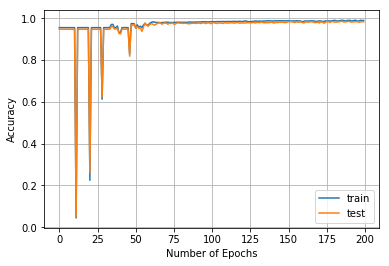

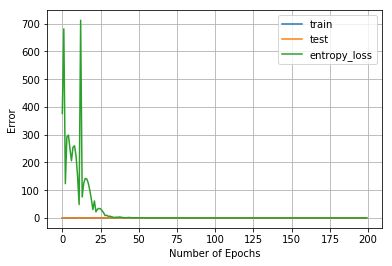

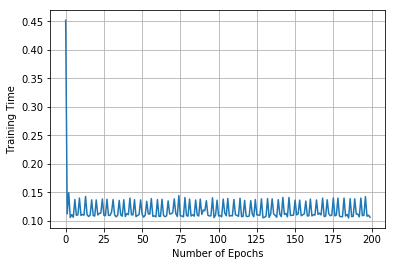

In [9]:
plt.figure()
plt.grid(True)
plt.plot(train_acc)
plt.plot(test_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

plt.figure()
plt.grid(True)
plt.plot(1-np.asarray(train_acc))
plt.plot(1-np.asarray(test_acc))
plt.plot(epo_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Error')
plt.legend(['train', 'test', 'entropy_loss'])

plt.figure()
plt.grid(True)
plt.plot(epo_time)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Time')